In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate
import optuna

In [21]:
X, Y = make_classification(n_samples=10000)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

In [19]:
def print_comparison(var_list, train_score, test_score):
    line1, = plt.plot(var_list, train_score, 'b', label='Train Score')
    line2, = plt.plot(var_list, test_score, 'r', label='Test Score')


def register_score(model, score_list, X, Y):
    return score_list.append(roc_auc_score(Y, model.predict_proba(X)[:,1]))


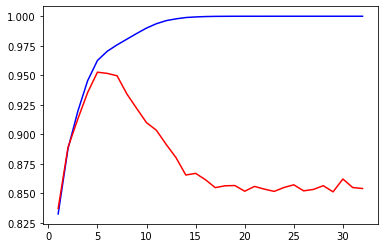

In [27]:
max_depths = np.linspace(1, 32, 32, endpoint=True)

train_score = []
test_score = []

for max_depth in max_depths:
    dct = DecisionTreeClassifier(max_depth=max_depth)
    dct.fit(X_train, Y_train)
    
    register_score(dct, train_score, X_train, Y_train)
    register_score(dct, test_score, X_test, Y_test)

print_comparison(var_list, train_score, test_score)

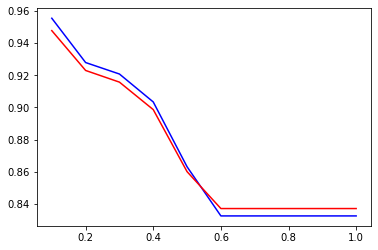

In [24]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)

train_score = []
test_score = []

for min_samples_split in min_samples_splits:
    dct = DecisionTreeClassifier(min_samples_split=min_samples_split)
    dct.fit(X_train, Y_train)
    
    register_score(dct, train_score, X_train, Y_train)
    register_score(dct, test_score, X_test, Y_test)

print_comparison(min_samples_splits, train_score, test_score)

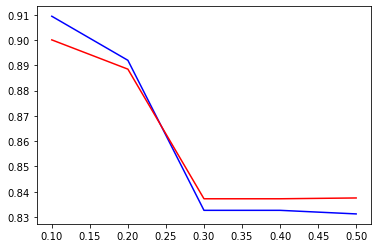

In [25]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)

train_score = []
test_score = []

for min_samples_leaf in min_samples_leafs:
    dct = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dct.fit(X_train, Y_train)
    
    register_score(dct, train_score, X_train, Y_train)
    register_score(dct, test_score, X_test, Y_test)

print_comparison(min_samples_leafs, train_score, test_score)

In [53]:
def objective(trial):

    dct_min_samples_split = trial.suggest_float('dct_min_samples_split', 0.1, 1.0, step=0.1)
    dct_min_samples_leaf = trial.suggest_float('dct_min_samples_leaf', 0.1, 0.5, step=0.1)
    dct_max_depth = trial.suggest_int('dct_max_depth', 1, 32, step=1)

    dct = DecisionTreeClassifier(min_samples_split=dct_min_samples_split,
                                 min_samples_leaf=dct_min_samples_leaf,
                                 max_depth=dct_max_depth)
    dct.fit(X_train, Y_train)

    Y_predict = dct.predict_proba(X_train)[:,1]
    train_auc = roc_auc_score(Y_train, Y_predict)
    
    Y_predict = dct.predict_proba(X_test)[:,1]
    test_auc = roc_auc_score(Y_test, Y_predict)

    return train_auc, test_auc


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="Study with multi-objective", directions=["maximize", "maximize"])
study.optimize(objective, n_trials=30, timeout=300)

print(study.best_trials)

[FrozenTrial(number=8, values=[0.9094496243899484, 0.9000957617120863], datetime_start=datetime.datetime(2021, 11, 13, 22, 54, 3, 237204), datetime_complete=datetime.datetime(2021, 11, 13, 22, 54, 3, 278205), params={'dct_min_samples_split': 0.2, 'dct_min_samples_leaf': 0.1, 'dct_max_depth': 17}, distributions={'dct_min_samples_split': DiscreteUniformDistribution(high=1.0, low=0.1, q=0.1), 'dct_min_samples_leaf': DiscreteUniformDistribution(high=0.5, low=0.1, q=0.1), 'dct_max_depth': IntUniformDistribution(high=32, low=1, step=1)}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, trial_id=8, state=TrialState.COMPLETE, value=None)]


In [103]:
def objective(trial):
    dct_min_samples_split = trial.suggest_float('dct_min_samples_split', 0.1, 1.0, step=0.1)
    dct_min_samples_leaf = trial.suggest_float('dct_min_samples_leaf', 0.1, 0.5, step=0.1)
    dct_max_depth = trial.suggest_int('dct_max_depth', 1, 32, step=1)

    dct = DecisionTreeClassifier(min_samples_split=dct_min_samples_split,
                                 min_samples_leaf=dct_min_samples_leaf,
                                 max_depth=dct_max_depth)

    list_of_score = cross_validate(dct, X, Y, cv=7, scoring=("roc_auc","neg_log_loss","f1"))
    score = sum(list_of_score['test_roc_auc']) / len(list_of_score['test_roc_auc'])
    return score, score


optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="Study with cross validation", directions=["maximize", "maximize"])
study.optimize(objective, n_trials=10, timeout=300)

plt1 = optuna.visualization.plot_edf(study)
plt2 = optuna.visualization.plot_param_importances(study)

plt1.update_layout(width=1000,height=500)
plt2.update_layout(width=1000,height=500)

plt1.show()
plt2.show()